In [1]:
import sys
import os

# Add the project root directory to sys.path
project_root = r'C:\Users\Ian Bracken\Desktop\WebDev\nba-prediction-model'
if project_root not in sys.path:
    sys.path.append(project_root)

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
import pickle
from postgres.config import SessionLocal
from postgres.models import AdvancedPlayerStats, ClusteredPlayers





In [3]:
session = SessionLocal()

players = session.query(AdvancedPlayerStats).all()
# Convert ORM objects to a list of dictionaries
data = []
for player in players:
    player_dict = {column.name: getattr(player, column.name) for column in player.__table__.columns}
    data.append(player_dict)

df = pd.DataFrame(data)

df.set_index('PLAYER', inplace=True)


df = df[df['GP'] >= 10]
df = df[df['MIN'] >= 15]
# Perhaps a poor practice and should remove them in the scraping algorithm
df = df.drop(columns=['id', 'TEAM', 'W', 'L', 'GP', 'DREB', 'STL', 'BLK'])
# df = df.astype(float)
df.head()

,AGE,MIN,OFFRTG,DEFRTG,NETRTG,AST_PERCENT,AST_TO,AST_RATIO,OREB_PERCENT,DREB_PERCENT,...,FGM_UAST_PERCENT,DEF_RTG,DREB_PERCENT_TEAM,STL_PERCENT,BLK_PERCENT,OPP_PTS_OFFTO,OPP_PTS_2ND_CHANCE,OPP_PTS_FB,OPP_PTS_PAINT,DEFWS
PLAYER,,,,,,,,,,,,,,,,,,,,,
nicolas batum,36,17.8,107.1,101.5,5.6,10.6,2.85,29.1,3.5,11.2,...,9.3,101.5,11.2,18.4,22.9,6.5,4.6,5.3,15.9,0.106
alperen sengun,22,31.4,115.0,106.3,8.7,25.2,2.02,19.8,9.8,21.7,...,53.1,106.3,21.7,24.2,27.5,9.5,8.4,8.4,30.6,0.140
amir coffey,27,25.2,109.0,106.4,2.6,6.7,1.67,11.3,2.2,7.8,...,17.0,106.4,7.8,12.2,3.2,10.5,6.2,8.6,25.3,0.113
deni avdija,24,28.0,110.2,117.9,-7.7,17.2,1.36,18.5,4.3,17.6,...,41.3,117.9,17.6,22.7,20.7,11.6,8.7,10.7,27.5,0.031
donte divincenzo,27,26.4,110.5,109.2,1.3,20.1,2.03,23.6,2.1,10.8,...,25.0,109.2,10.8,27.3,5.9,11.1,8.3,8.1,25.7,0.098


Removes the team column from the dataframe for now. It may be added back for future analysis but as a string it causes problems for the clustering algorithm. Also dropping players who have played less than 10 games because the sample size is so small.

In [4]:
dfPlayerCol = df.reset_index()
dfPlayerCol

,PLAYER,AGE,MIN,OFFRTG,DEFRTG,NETRTG,AST_PERCENT,AST_TO,AST_RATIO,OREB_PERCENT,...,FGM_UAST_PERCENT,DEF_RTG,DREB_PERCENT_TEAM,STL_PERCENT,BLK_PERCENT,OPP_PTS_OFFTO,OPP_PTS_2ND_CHANCE,OPP_PTS_FB,OPP_PTS_PAINT,DEFWS
0,nicolas batum,36,17.8,107.1,101.5,5.6,10.6,2.85,29.1,3.5,...,9.3,101.5,11.2,18.4,22.9,6.5,4.6,5.3,15.9,0.106
1,alperen sengun,22,31.4,115.0,106.3,8.7,25.2,2.02,19.8,9.8,...,53.1,106.3,21.7,24.2,27.5,9.5,8.4,8.4,30.6,0.140
2,amir coffey,27,25.2,109.0,106.4,2.6,6.7,1.67,11.3,2.2,...,17.0,106.4,7.8,12.2,3.2,10.5,6.2,8.6,25.3,0.113
3,deni avdija,24,28.0,110.2,117.9,-7.7,17.2,1.36,18.5,4.3,...,41.3,117.9,17.6,22.7,20.7,11.6,8.7,10.7,27.5,0.031
4,donte divincenzo,27,26.4,110.5,109.2,1.3,20.1,2.03,23.6,2.1,...,25.0,109.2,10.8,27.3,5.9,11.1,8.3,8.1,25.7,0.098
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
304,jordan clarkson,32,25.6,105.2,117.6,-12.4,26.2,1.53,18.1,2.4,...,60.5,117.6,10.1,20.7,14.9,13.5,10.0,10.2,27.8,0.031
305,herbert jones,26,32.4,111.8,112.5,-0.7,13.4,1.86,22.3,3.3,...,21.3,112.5,8.5,27.0,11.1,12.7,9.9,10.5,34.5,0.088
306,day'ron sharpe,23,17.3,108.4,111.1,-2.8,13.3,1.36,14.9,14.4,...,43.3,111.1,21.8,26.9,32.1,7.7,5.2,5.2,14.9,0.053
307,micah potter,26,17.3,106.6,108.9,-2.4,6.3,1.30,17.6,5.9,...,10.5,108.9,14.7,8.3,21.4,4.9,5.3,6.6,16.1,0.063


In [5]:
features = list(df.columns)
# Removes the column titles for data processing
x = df.loc[:, features].values
# Good practice to scale the data down based on variance
x = StandardScaler().fit_transform(x) 


Feature refers to the data that you are using in ML model to make predictions. Feature engineering is the process of finding the best features for the model. 

In [6]:
variance_list = []
for n_components in range(2,len(df.columns)):
    # Dimensionality Reduction
    pca = PCA(n_components=n_components)
    components = pca.fit_transform(x)
    variance = sum(pca.explained_variance_ratio_)
    variance_list.append(variance)
    print(f"Variance with {n_components} components: {variance}")


Variance with 2 components: 0.43010471996365024
Variance with 3 components: 0.5346258171337923
Variance with 4 components: 0.6347505227773538
Variance with 5 components: 0.6882848481849312
Variance with 6 components: 0.7324563643163707
Variance with 7 components: 0.7678527763410083
Variance with 8 components: 0.7988706681923522
Variance with 9 components: 0.8241566319986472
Variance with 10 components: 0.8479912093126157
Variance with 11 components: 0.8684490258880854
Variance with 12 components: 0.8881909871748445
Variance with 13 components: 0.9040797738777638
Variance with 14 components: 0.9189174318383752
Variance with 15 components: 0.9332862375694916
Variance with 16 components: 0.9446806505613384
Variance with 17 components: 0.9548142285678141
Variance with 18 components: 0.9637492695395065
Variance with 19 components: 0.9713142037490787
Variance with 20 components: 0.9780519216350175
Variance with 21 components: 0.983348461243405
Variance with 22 components: 0.9875178816706969


This helps determine how much variance in the dataset is captured as the number of components increases. This will aid in choosing the ideal number of components for dimensionality reduction.

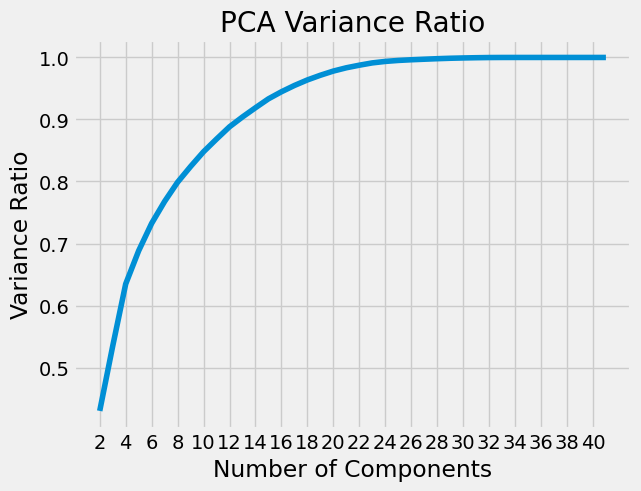

In [7]:
#Useful graph for visualization of ratio changes
plt.style.use('fivethirtyeight')
pca_fig, ax = plt.subplots()
ax.plot(range(2,len(df.columns)), variance_list)
ax.set_xlabel('Number of Components')
ax.set_ylabel('Variance Ratio')
ax.set_xticks(np.arange(2, len(df.columns), 2))
ax.set_title('PCA Variance Ratio')
pca_fig.savefig('../images/PCA_Variance_Ratio.png')

In [8]:
from numpy import diff
diff_variance = diff(variance_list)
print(diff_variance)

[1.04521097e-01 1.00124706e-01 5.35343254e-02 4.41715161e-02
 3.53964120e-02 3.10178919e-02 2.52859638e-02 2.38345773e-02
 2.04578166e-02 1.97419613e-02 1.58887867e-02 1.48376580e-02
 1.43688057e-02 1.13944130e-02 1.01335780e-02 8.93504097e-03
 7.56493421e-03 6.73771789e-03 5.29653961e-03 4.16942043e-03
 3.70730402e-03 2.37896436e-03 1.59011623e-03 1.08862318e-03
 8.75394368e-04 8.44312912e-04 7.06527092e-04 4.90176113e-04
 3.82541718e-04 2.87038679e-04 1.11423212e-04 1.90628596e-05
 5.33049514e-07 8.94882368e-08 5.69205671e-09 3.71396203e-09
 1.64390013e-09 0.00000000e+00 0.00000000e+00]


This calculates the difference between consecutive elements in the variance_list array. Slope calculus, used to determine the "elbow point" in PCA which is where the rate of variance slows down

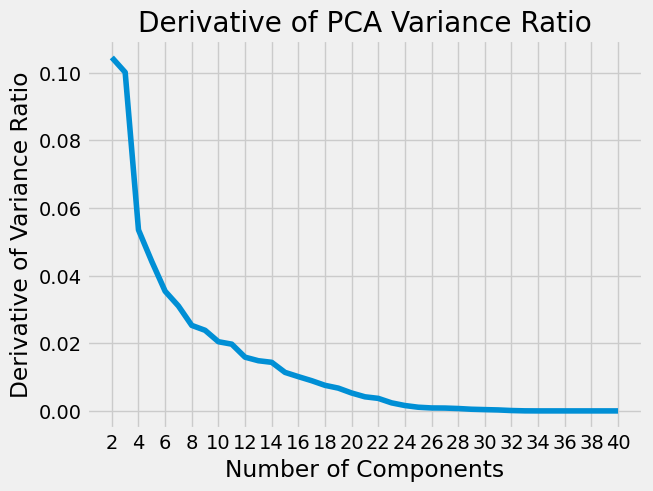

In [9]:
pca_deriv, ax = plt.subplots()
ax.plot(range(2, len(df.columns) - 1), diff_variance)
ax.set_xlabel('Number of Components')
ax.set_ylabel('Derivative of Variance Ratio')
ax.set_xticks(np.arange(2, len(df.columns), 2))
ax.set_title('Derivative of PCA Variance Ratio')
pca_deriv.savefig('../images/PCA_Derivative.png')

Good data should have a high PCA Variance Ratio along with a low Derivative of the Variance Ratio. By using both criteria, you balance data representativeness (high variance ratio) and computational efficiency (low derivative).

In [10]:
n_comp = 16
pca = PCA(n_components=n_comp)

# Reducing the dimensions of the data
components = pca.fit_transform(x)

pca_df = pd.DataFrame(data = components, columns = [f'PC{i}' for i in range(1, n_comp + 1)])

pca_df['PLAYER'] = dfPlayerCol['PLAYER']
pca_df = pca_df[['PLAYER'] + [f'PC{i}' for i in range(1, n_comp + 1)]]
pca_df

print(pca.explained_variance_ratio_)
print(sum(pca.explained_variance_ratio_))

[0.21888033 0.21122439 0.1045211  0.10012471 0.05353433 0.04417152
 0.03539641 0.03101789 0.02528596 0.02383458 0.02045782 0.01974196
 0.01588879 0.01483766 0.01436881 0.01139441]
0.9446806505613384


In [11]:
x = np.column_stack([pca_df[f'PC{i}'] for i in range(1, n_comp)])

# We want a high silhouette score along with meaningful analysis
silhouette = []

for n_clusters in range(2, 32):
    kmeans = KMeans(n_clusters=n_clusters, random_state = 4)
    cluster_labels = kmeans.fit_predict(x)
    centers = kmeans.cluster_centers_
    score = silhouette_score(x, cluster_labels)
    silhouette.append(score)
    print(f"Silhouette Score with {n_clusters} clusters: {score}")

Silhouette Score with 2 clusters: 0.1481239546983177
Silhouette Score with 3 clusters: 0.18850797262285837
Silhouette Score with 4 clusters: 0.15777075124815673
Silhouette Score with 5 clusters: 0.13387211092971502
Silhouette Score with 6 clusters: 0.11517952464989273
Silhouette Score with 7 clusters: 0.12547518443090735
Silhouette Score with 8 clusters: 0.11467560383459424
Silhouette Score with 9 clusters: 0.10097113201426502


Silhouette Score with 10 clusters: 0.09074343290419344
Silhouette Score with 11 clusters: 0.09618086360572378
Silhouette Score with 12 clusters: 0.09099309412478797
Silhouette Score with 13 clusters: 0.09235247072000488
Silhouette Score with 14 clusters: 0.09181491534996479
Silhouette Score with 15 clusters: 0.09574437332349746
Silhouette Score with 16 clusters: 0.08780744503618501
Silhouette Score with 17 clusters: 0.0925651196922326
Silhouette Score with 18 clusters: 0.09360285399590536
Silhouette Score with 19 clusters: 0.08976796020338834
Silhouette Score with 20 clusters: 0.0900905925308632
Silhouette Score with 21 clusters: 0.08075234658979309
Silhouette Score with 22 clusters: 0.0816236835389513
Silhouette Score with 23 clusters: 0.07897591069314343
Silhouette Score with 24 clusters: 0.08343052980933773
Silhouette Score with 25 clusters: 0.08236046095496329
Silhouette Score with 26 clusters: 0.07632874598091635
Silhouette Score with 27 clusters: 0.07780046301330114
Silhouette Sc

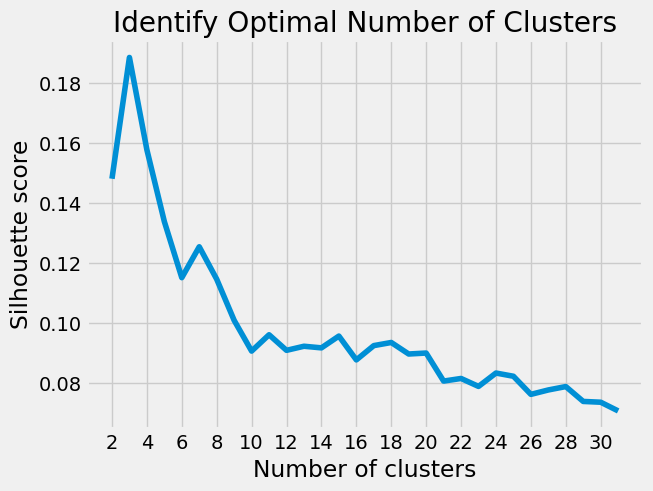

In [12]:
plt.style.use('fivethirtyeight')
silhouette_fig, ax = plt.subplots()
ax.plot(range(2,2 + len(silhouette)), silhouette)
ax.set_xlabel('Number of clusters')
ax.set_ylabel('Silhouette score')
ax.set_xticks(np.arange(2, 2+len(silhouette), 2))
ax.set_title('Identify Optimal Number of Clusters')
silhouette_fig.savefig('../images/Optimal_Clusters.png')

In [13]:
silhouette_diff = []

for i in range(1, len(silhouette)):
    improvement = 1 - ((1-silhouette[i]) / (1 - silhouette[i - 1]))
    silhouette_diff.append(improvement)
    print(f"for n_cluseter = {i + 2}, improvement = {improvement}") 

for n_cluseter = 3, improvement = 0.047405979012168475
for n_cluseter = 4, improvement = -0.037877416336484115
for n_cluseter = 5, improvement = -0.02837545757744553
for n_cluseter = 6, improvement = -0.021581785456518565
for n_cluseter = 7, improvement = 0.011635874245496836
for n_cluseter = 8, improvement = -0.012349084215849793
for n_cluseter = 9, improvement = -0.015479604854093276
for n_cluseter = 10, improvement = -0.011376385647088982
for n_cluseter = 11, improvement = 0.00598008405800976
for n_cluseter = 12, improvement = -0.005739831424273811
for n_cluseter = 13, improvement = 0.0014954524398338442
for n_cluseter = 14, improvement = -0.0005922512348670583
for n_cluseter = 15, improvement = 0.004326714939440923
for n_cluseter = 16, improvement = -0.008777305944430713
for n_cluseter = 17, improvement = 0.005215647321563988
for n_cluseter = 18, improvement = 0.0011435909354959861
for n_cluseter = 19, improvement = -0.004230919977433079
for n_cluseter = 20, improvement = 0.0003544

C:\conda_tmp\ipykernel_11156\1289475222.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(['{:,.0%}'.format(x) for x in vals])


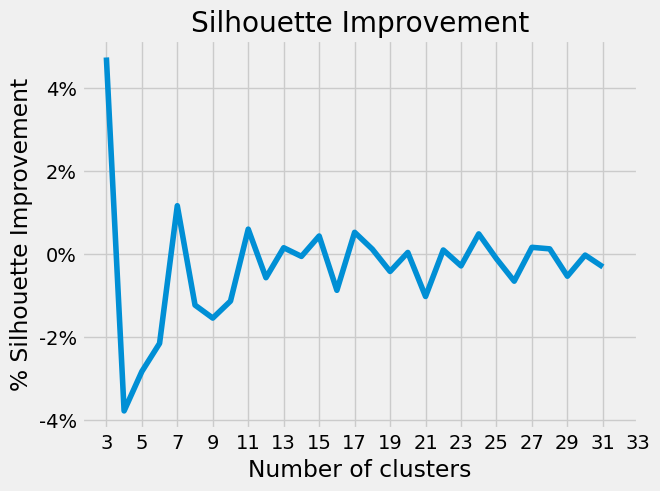

In [14]:
plt.style.use('fivethirtyeight')
silhouette_improvement_fig, ax = plt.subplots()
ax.plot(range(3, 2 + len(silhouette)), silhouette_diff)
ax.set_xlabel('Number of clusters')
ax.set_ylabel('% Silhouette Improvement')
ax.set_xticks(np.arange(3, 4 + len(silhouette), 2))
vals = ax.get_yticks()
ax.set_yticklabels(['{:,.0%}'.format(x) for x in vals])
ax.set_title('Silhouette Improvement')
silhouette_fig.savefig('../images/Silhouette_Improvement.png')

In [15]:
kmeans = KMeans(n_clusters = 15, random_state = 4)

kmeans.fit(x)

y_kmeans = kmeans.predict(x)
with open("../models/clusterMode.sav", 'wb') as f:
    pickle.dump(kmeans, f)

In [16]:
df_cluster = pd.DataFrame()

df_cluster['Player'] = dfPlayerCol['PLAYER']
df_cluster['Cluster'] = y_kmeans
df_cluster.head()

,Player,Cluster
0,nicolas batum,0
1,alperen sengun,6
2,amir coffey,14
3,deni avdija,3
4,donte divincenzo,14


In [17]:
df_cluster.columns = df_cluster.columns.str.upper()
for _, row in df_cluster.iterrows():
    existing_player = session.query(ClusteredPlayers).filter_by(PLAYER=row['PLAYER']).first()
    if existing_player:
        # Update the cluster value if the player exists
        existing_player.CLUSTER = row['CLUSTER']
    else:
        # Convert the row to a dictionary and pass it to the model
        clustered_player = ClusteredPlayers(
            PLAYER=row['PLAYER'],
            CLUSTER=row['CLUSTER']
        )
        session.add(clustered_player)
session.commit()

session.close()